In [14]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
from cv2 import cv2
from matplotlib import pyplot as plt
from numpy import random

print("Reading Dataframe")
info = pd.read_csv("data/dataset_raw/MIAS/Info.txt", sep=" ")
info = info.drop('Unnamed: 7', axis=1)
info.head()

In [17]:
label = []
for i in range(len(info)):
    if info.CLASS[i] != 'NORM':
        label.append(1)
    else:
        label.append(0)
label = np.array(label)
print(f"Cantidad de Imagenes: {len(label)}, Normales = {len(label) - np.sum(label)}, No normales= {np.sum(label)}")
print("Len de Label:", len(label))

Cantidad de Imagenes: 330, Normales = 207, No normales= 123
Len de Label: 330


In [18]:
# define the every images filepaths in to list
img_name = []
imgs_path = "data/dataset_raw/MIAS/MIAS-RAW/"
for i in range(len(label)):
    img_name.append(imgs_path + info.REFNUM[i] + '.pgm')

count = 0
remove = True
temp_label = []
temp_img_name = []

for i, lbl in enumerate(label.tolist()):
    if lbl == 0 and remove == True:
        count = count + 1
        if count >= 84:
            remove = False
    else:
        temp_label.append(lbl)
        temp_img_name.append(img_name[i])

label = np.array(temp_label)
img_name = temp_img_name
print("Len Label:", len(label))

img_name = np.array(img_name)
print("Shape de img_name", img_name.shape)

Len Label: 246
Shape de img_name (246,)


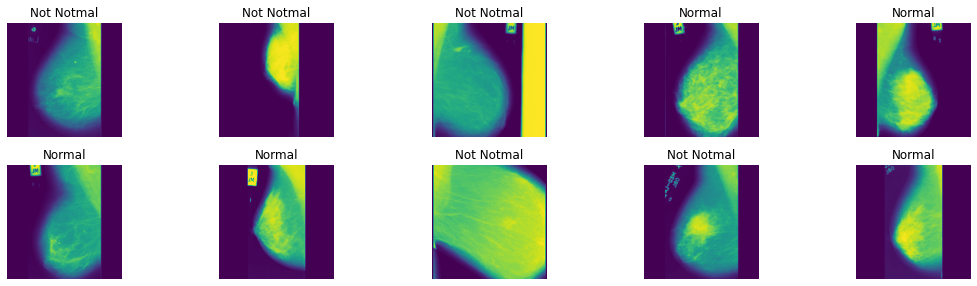

In [19]:
# view image random images
def view_25_random_image():
    fig = plt.figure(figsize = (15, 10))
    for i in range(10):
        rand = random.randint(0,len(label))
        ax = plt.subplot(5, 5, i+1)

        img = cv2.imread(img_name[rand], 0)
        img = cv2.resize(img, (256,256))
        if label[rand] == 1:
            plt.title('Not Notmal')
        else:
            plt.title('Normal')
        plt.tight_layout()
        plt.axis('off')
        plt.imshow(img)
    fig.savefig('random_25_image_fig.png')

random_images = view_25_random_image()

In [20]:
# Aumentación de datos
img_path = []
last_label = []
IMG_SIZE = 128

for i in range(len(img_name)):
    img = cv2.imread(img_name[i], 0)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    rows, cols= img.shape
    for angle in range(180):
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle*2, 1)    #Rotate 0 degree
            img_rotated = cv2.warpAffine(img, M, (IMG_SIZE, IMG_SIZE))
            img_path.append(img_rotated)
            if label[i] == 1:
                last_label.append(1)
            else:
                last_label.append(0)
# print(last_label)
print("Cantidad de labels",len(last_label))
print("Cantidad de img path",len(img_path))
# print("Primer",img_path[0])
img_path = np.array(img_path)
last_label = np.array(last_label)
print("Shape:",img_path.shape)


img_path = img_path.reshape((-1,IMG_SIZE,IMG_SIZE,1))
print("Nuevo Shape:",img_path.shape)

Cantidad de labels 44280
Cantidad de img path 44280
Shape: (44280, 128, 128)
Nuevo Shape: (44280, 128, 128, 1)


In [22]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(img_path, last_label, test_size = 0.2, random_state = 42)
print(len(x_train),len(x_test),len(y_train),len(y_test))

35424 8856 35424 8856


In [24]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.activations import *
from keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from time import time
import tensorflow as tf

reg = tf.keras.regularizers.L2(l2=1e-5)
ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None)


model = Sequential()
model.add(Conv2D(32,
                 kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer = ini,
                 input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(Conv2D(64,
                 kernel_size=(3,3),
                 kernel_initializer = ini,
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64,
                 kernel_size=(3,3),
                 kernel_initializer = ini,
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Dense(64,
                kernel_initializer = ini,
                activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-3)

model.compile(optimizer=optimizer,
              loss= 'binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 64)        0         
_________________________________________________________________
dense (Dense)                (None, 30, 30, 64)        4

In [25]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3,restore_best_weights=True, verbose=1)

check_point_filepath = 'temp/'

model_check_point = ModelCheckpoint(filepath =check_point_filepath, monitor='val_loss', verbose=1, save_best_only=True,
                                    save_weights_only=False, mode='auto', save_freq='epoch')


In [26]:
train = True
if train:
    epochs=100
    history = model.fit(x_train,
                 y_train,
                 validation_split=0.2,
                 epochs=epochs,
                 batch_size=128,
                 callbacks=[early_stop, model_check_point])
else:
    model = tf.keras.models.load_model('temp/')


Epoch 1/100
222/222 [==============================] - 58s 93ms/step - loss: 0.6937 - accuracy: 0.5017 - val_loss: 0.6935 - val_accuracy: 0.5080

In [27]:
from src.utils.utils import Save_model_summary_txt_architecture_json

Save_model_summary_txt_architecture_json(model)

Summary en txt creado
Arquitectura en json creado


In [35]:
# history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:

import mlflow
from mlflow.entities import Metric
from mlflow.tracking import MlflowClient
from src.parameters.model_parameters import *
mlflow_client = MlflowClient()
EXPERIMENT_NAME = "MIAS_BM_N"
try:
    EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME)
except:
    EXPERIMENT_ID = mlflow_client.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
name_red = "new_CNN"
transfer_learning = False
batch_size=128
learning_rate = 1e-3
loss = "Adam"
dataset = "Mias"
validation_split = "0.2"
with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name=name_red) as active_run:
    # with mlflow.start_run(run_name=name_red) as active_run:
    # mlflow_client = MlflowClient()
    # experiment_id = mlflow_client.create_experiment("Mamografías CNNs experimentos")
    # experiment_id = "0"
    # run = mlflow_client.create_run(experiment_id)
    all_metrics = []
    # f1, val_f1 = get_F1_scores(history)
    for metric_name in history.history:
        for i in history.epoch:
            metric = Metric(
                key=metric_name,
                value=history.history[metric_name][i],
                timestamp=0,
                step=i,
            )
            all_metrics.append(metric)
    # all_metrics = all_metrics + f1 + val_f1

    mlflow_client.log_batch(run_id=active_run.info.run_id, metrics=all_metrics)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="batch size", value=batch_size)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="learning rate", value=learning_rate)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="epochs", value=epochs)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="optimizer", value=optimizer.__class__.__name__)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="Loss", value=loss)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="DB", value=dataset)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="Transfer Learning", value=transfer_learning)
    # mlflow_client.log_param(run_id=active_run.info.run_id, key="Folder para clasificar", value=mode_classification)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="Split test", value=validation_split)
    # mlflow.log_artifact("temp/", artifact_path="arquitectura")
    # if config.LOG_JSON_TXT_MODEL_MLFlow:
    #     mlflow.log_artifact("temp/summary_model.txt", artifact_path="arquitectura")
    #     mlflow.log_artifact("temp/architecture.json", artifact_path="arquitectura")
    # if config.LOG_MODEL_MLFlow:
    #     mlflow_client.log_artifacts(run_id=active_run.info.run_id, local_dir="temp/model/")

    mlflow_client.log_batch(run_id=active_run.info.run_id, metrics=all_metrics)
    print("Todas las metricas guardadas")

Todas las metricas guardadas
